In [1]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""));


import pandas as pd

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.width', 1000)

In [2]:
import os
from collections import Counter

import numpy as np
import cv2

from matplotlib import pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import svm

from pycm import *

import pickle
import snapml

In [3]:
ksize = 31

def read_img(path, normal_read):
    if normal_read:
        img = np.array(cv2.imread(path))

        cond1 = np.logical_and((img[:,:,0]==255), (img[:,:,1]==255))
        cond2 = np.logical_and(cond1, (img[:,:,2]==255))

        target = np.zeros((img.shape[0], img.shape[1]))
        target[:,:] = np.where(cond2, 0, 1)
        
        return target
    else:
        img = cv2.imread(path)
        scale = 1
        delta = 0
        ddepth = cv2.CV_16S
        grad_x = cv2.Sobel(img, ddepth, 1, 0, ksize=ksize, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        grad_y = cv2.Sobel(img, ddepth, 0, 1, ksize=ksize, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

        rs = np.zeros((img.shape[0], img.shape[1], 2))
        rs[:,:,0] = np.amax(grad_x,2)
        rs[:,:,1] = np.amax(grad_y,2)
        return np.amax(rs, 2)

In [4]:
def flatten_data(img):
    return [item for sublist in img for item in sublist]

In [5]:
list_category = sorted(os.listdir('./dataset/'))
category_mapping = {}
for i in range(len(list_category)):
    category_mapping[i] = list_category[i]

In [6]:
train_ratio = 0.7

val_x_1_img = []
val_x_2_img = []
val_x_1 = []
val_x_2 = []
val_y = []

for cat in tqdm(list_category):
    list_file_by_cat = os.listdir(os.path.join('./dataset', cat))
    train_length = int(len(list_file_by_cat) * train_ratio)
    
    for fn in list_file_by_cat[train_length:]:
        img = read_img(os.path.join('./dataset/', cat, fn), True)
        val_x_1.append(flatten_data(img))
        val_x_1_img.append(img)
        
        img = read_img(os.path.join('./dataset/', cat, fn), False)
        val_x_2.append(flatten_data(img))
        val_x_2_img.append(img)
        
        val_y.append(cat)

100%|██████████| 250/250 [02:14<00:00,  1.86it/s]


In [7]:
def get_model_predict(model, inp, val):
    rs = model.decision_function(np.array(inp), n_jobs=10)[0]
    top_rs = rs.argsort()[-10:][::-1]
    
    txt = ''
    for cat in top_rs[:1]:
        if val == category_mapping[cat]:
            txt = f'[{val}]'
        else:
            txt = category_mapping[cat]
    print(f'Top 1: {txt}')
    
    for cat in top_rs[1:3]:
        if val == category_mapping[cat]:
            txt += f', [{val}]'
        else:
            txt += f', {category_mapping[cat]}'
    
    print(f'Top 3: {txt}')
    
    for cat in top_rs[3:]:
        if val == category_mapping[cat]:
            txt += f', [{val}]'
        else:
            txt += f', {category_mapping[cat]}'
    
    print(f'Top 10: {txt}')

In [8]:
with open('model_1.pkl', "rb") as f:
    model_1 = pickle.load(f)
with open('model_2.pkl', "rb") as f:
    model_2 = pickle.load(f)

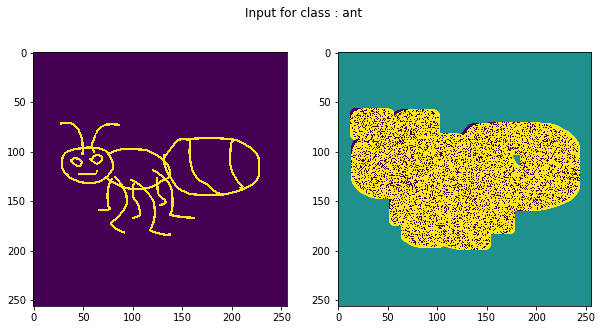

In [20]:
i = 95
fig=plt.figure(figsize=(10,5))
fig.suptitle(f'Input for class : {val_y[i]}')
fig.add_subplot(1, 2, 1)
plt.imshow(val_x_1_img[i])
fig.add_subplot(1, 2, 2)
plt.imshow(val_x_2_img[i])

In [21]:
print('====== Normal-Read Model Prediction: ')
get_model_predict(model_1, [val_x_1[i]], val_y[i])
print('====== Sobel-Applied Model Prediction: ')
get_model_predict(model_2, [val_x_2[i]], val_y[i])

====== Normal-Read Model Prediction: 
Top 1: bridge
Top 3: bridge, [ant], eye
Top 10: bridge, [ant], eye, camera, computer-mouse, satellite, cannon, crocodile, tiger, hot air balloon
====== Sobel-Applied Model Prediction: 
Top 1: dog
Top 3: dog, blimp, cow
Top 10: dog, blimp, cow, seagull, rooster, pipe (for smoking), zebra, duck, scorpion, bus


In [11]:
# 5432
# 99
# 89